### 24 Jan 2023

### This code is almost entirely written by Dr. Tasha Snow. Minor edits from Elena Savidge.

# Code for seal data processing (uninterpolated version for supplement figs). 
Here we want to look at the uninterpolated data to make Supplement figures S1 and S2.

In [7]:
from glob import glob
import pandas as pd
import re
import os
import gsw
import numpy as np
import matplotlib.pyplot as plt
from netCDF4 import Dataset
import pandas as pd
import netCDF4
#import pickle

In [1]:
pwd

'/Users/elenasavidge/Documents/Documents - Elena’s MacBook Pro/Sealtag/savidge23_manuscriptcode'

### Define functions (these stay the same)

In [2]:
def read_nc(fname):
    '''Read in NetCDF files. Add station and datetime columns and calculate depth.'''
    
    # Read in netcdf variables 
    seal = Dataset(fname, mode='r')
    name = os.path.basename(fname).split('.')[0]
    
    lat = seal.variables['LATITUDE'][:]
    lon = seal.variables['LONGITUDE'][:]
    temp = seal.variables['TEMP_ADJUSTED'][:]
    pres = seal.variables['PRES_ADJUSTED'][:]
    try:
        psal = seal.variables['PSAL_ADJUSTED'][:]
    except:
        psal = np.zeros((temp.shape[0],temp.shape[1]))
    jday = seal.variables['JULD'][:]
    
    timetrans = pd.DataFrame((pd.to_datetime('1950-01-01') + pd.to_timedelta(jday,unit='d')),columns=['Datetime'])
    latlon= pd.concat([pd.DataFrame(lat,columns=['LATITUDE']),pd.DataFrame(lon,columns=['LONGITUDE'])],axis=1)

    # Flatten 2d dataframes so each station's depth measurement has its own row, and concatenate 
    temp_frame = pd.concat([timetrans,latlon,pd.DataFrame(temp)],axis=1)
    temp_frame = pd.melt(temp_frame,id_vars=['Datetime','LATITUDE','LONGITUDE'],value_name='Temperature [C]')
    temp_frame = temp_frame.set_index('Datetime')

    psal_frame = pd.concat([timetrans,pd.DataFrame(psal)],axis=1)
    psal_frame = pd.melt(psal_frame,id_vars=['Datetime'],value_name='Salinity [PSU]')
    psal_frame = psal_frame.set_index('Datetime')

    pres_frame = pd.concat([timetrans,pd.DataFrame(pres)],axis=1)
    pres_frame = pd.melt(pres_frame,id_vars=['Datetime'],value_name='Pressure [dbar]')
    pres_frame = pres_frame.set_index('Datetime')

    cast = pd.concat([temp_frame,psal_frame,pres_frame],axis=1)
    cast['Station'] = name

    cast = cast.reset_index()
    cast = cast.set_index('Pressure [dbar]')
    cast = cast.drop(columns = ['variable'],axis=1)
    
    # Remove bad pressure columns
    cast = cast[cast.index.notnull()]
    
    # Calculate depth so can reindex to that
    cast['z'] = -gsw.z_from_p(cast.index, cast['LATITUDE'])
    
    return cast

In [3]:
def proc_seal(cast,dive_type='seal'):
    '''Process CTD DataFrame. Meant for seal data. Needs to be one cast at a time.
    
    cast = DataFrame
    colindex = index interpolated across, by depth 'z' or 'Pressure [dbar]'
    
    cast columns of Datetime and Station will be removed and readded so as to not mess up interp 
    '''
#     cast = cast.reset_index()
#     cast = cast.set_index(cast.index)

    dt = cast.Datetime.min()
    name = cast.Station.min()
    try:
        cast = cast.drop(columns = ['Datetime','Station'],axis=1)
    except:
        cast = cast.drop(columns = ['Datetime'],axis=1)
    
    if dive_type=='seal':
        # Interpolate - cubic spline
        cast = seal_interp(cast,1,dive_type)

    # 08-Derive.
    cast = derive_csv(cast) 
    try:
        cast['Datetime'] = dt
        cast['Station'] = name
    except:
        cast['Datetime'] = dt
    
    return cast

In [4]:
def seal_interp(df,dz=1,dive_type='seal'):
    '''Interpolates all columns in a DataFrame based on index of either depth or pressure at intervals of dz (m). 
    Meant for seal CTD data. Cannot include strings/non-interprolationable data'''
    if dive_type=='seal':
        # New index to interpolate to goes down to max depth
        x2 = np.arange(0,df.index.max()+1,dz)
    if dive_type=='glider':
        x2 = np.arange(np.round(df.index.min()),df.index.max()+1,dz)
    col = df.columns
    # Interpolate using gsw's pchip interpolation, will get a wrong data error if index is not increasing
    # Interpolation from surface to max depth +1. Pchip errors if too few point, then this reverts to linear interp
    try: 
        y2 = [gsw.pchip_interp(df.index, df.iloc[:, i],x2) for i in range(len(col))]
    except:
        print ('Too few points - reverted to linear interpolation')
        y2 = [np.interp(x2,df.index, df.iloc[:, i]) for i in range(len(df.columns))]  
    stack = np.column_stack(y2)
    return pd.DataFrame(stack, index=x2,columns=col)

In [5]:
def derive_csv(self):
    """Compute SA, PT, and sigma0 from a csv pre-processed cast."""
    cast = self.copy()  # FIXME: Use MetaDataFrame to propagate lon, lat.
    p = cast.index.values.astype(float)
    cast['SA'] = gsw.SA_from_SP(cast['Salinity [PSU]'].values, p, cast['LONGITUDE'].values,  cast['LATITUDE'].values)
    cast['CT'] = gsw.CT_from_t(cast['SA'].values, cast['Temperature [C]'].values, p)
    cast['PT'] = gsw.pt0_from_t(cast['SA'].values, cast['Temperature [C]'].values, p)
    cast['z'] = -gsw.z_from_p(p, cast['LATITUDE'])
    cast['PD'] = gsw.sigma0(cast['SA'].values, cast['CT'].values)
    cast['N2'] = np.hstack([np.nan, gsw.Nsquared(cast['SA'].values, cast['CT'].values, p)[0]])
    return cast

### Run functions
Here is where I uncomment the line 'dive = proc_seal(dive,"no int") #without interpolation' and comment 'dive = proc_seal(dive) #with interpolation' (the opposite for data that is used for all other figures and analysis.

#### 2014 seal data

'Too few points - reverted to linear interpolation' -- some dives in 2014 do not have enough points for interpolation. That is a normal message.

In [8]:
# 2014 data

# Point to file names
fnames = glob('2014sealdata/ct*.nc')

try:
    del seal14
except:
    print ('no old variables to delete')

# Read and process all nc files in a directory, accounts for multiple dives in one file via date, dif locations per 
# date, and god forbid multiple dives on same day and location 
for fname in fnames:
    sealcat = []
    seal_data = read_nc(fname)
    name = os.path.basename(fname).split('.')[0]
    print (name)
    for dt in seal_data.Datetime.unique():
        dive_d = seal_data[seal_data['Datetime']==dt]
        for lat in dive_d.LATITUDE.unique():
            dive_l = dive_d[dive_d['LATITUDE']==lat]
            dup = 0
            for i in dive_l.index.duplicated(keep='first')[1:]:
                if i == False: 
                    break
                dup+=1
            for i in range(dup+1):
                dive = dive_l.iloc[i::(dup+1), :] # starting on i, at intervals of dup+1
                if dive.shape[0]>0:
#                     dive = proc_seal(dive) #with interpolation
                    dive = proc_seal(dive,"no int") #without interpolation
                    try: 
                        sealcat = pd.concat([sealcat,dive])
                    except:
                        sealcat = dive
                else:
                    print ((str(dt) + ' has no data'))
    # Makes faster
    try:
        seal14 = pd.concat([seal14,sealcat])
    except:
        seal14 = sealcat
                    
# Pickle data
#seal14.to_pickle('seal14_file')
seal14.to_pickle('seal14NI_file') #no interpolation

seal14.head(2)

no old variables to delete
ct104-EM889-13_prof 1
ct104-WF895-13_prof
ct104-EF838-13_prof 1
ct104-EM971-13_prof 1
ct14-106-06-prof 1
ct104-WM972-13_prof 1
ct37-762-08-prof 1
ct37-765-08-prof 1
ct104-WF858-13_prof 1
ct48-047-09-prof 1
ct104-EF960-13_prof 1
ct104-EM959-13_prof 1
ct104-EF970-13_prof 1
ct37-620-08-prof 1
ct104-WF893-13_prof 1
ct37-617-08-prof 1
ct104-WF963-13_prof
ct104-WM890-13_prof
ct104-EM961-13_prof 1
ct102-12798-13-prof 1
ct14-111-06-prof 1
ct37-598-08-prof 1
ct48-585b-09-prof 1
ct104-WF896-13_prof


,LATITUDE,LONGITUDE,Temperature [C],Salinity [PSU],z,SA,CT,PT,PD,N2,Datetime,Station
Pressure [dbar],,,,,,,,,,,,
2.000000,-73.985466,-103.313785,-0.714860,33.174992,1.979313,33.334145,-0.708269,-0.714911,26.668586,NaN,2014-02-12 05:30:59.999990400,ct104-EM889-13_prof 1
37.700001,-73.985466,-103.313785,-1.152812,33.786579,37.306824,33.949033,-1.149067,-1.153676,27.180188,0.000138,2014-02-12 05:30:59.999990400,ct104-EM889-13_prof 1


#### 2019 seal data

In [11]:
# 2019 data

# Point to file names
fnames = glob('2019sealdata/ct147/ct147*')

try:
    del seal19
except:
    print ('no old variables to delete')
    
# Read and process all nc files in a directory, accounts for multiple dives in one file via date, dif locations per 
# date, and god forbid multiple dives on same day and location 
for fname in fnames:
    sealcat = []
    seal_data = read_nc(fname)
    name = os.path.basename(fname).split('.')[0]
    print (name)
    for dt in seal_data.Datetime.unique():
        dive_d = seal_data[seal_data['Datetime']==dt]
        for lat in dive_d.LATITUDE.unique():
            dive_l = dive_d[dive_d['LATITUDE']==lat]
            dup = 0
            for i in dive_l.index.duplicated(keep='first')[1:]:
                if i == False: 
                    break
                dup+=1
            for i in range(dup+1):
                dive = dive_l.iloc[i::(dup+1), :] # starting on i, at intervals of dup+1
                if dive.shape[0]>0:
#                     dive = proc_seal(dive) #with interpolation
                    dive = proc_seal(dive,"no int") #without interpolation
                    try: 
                        sealcat = pd.concat([sealcat,dive])
                    except:
                        sealcat = dive
                else:
                    print ((str(dt) + ' has no data'))
    # Makes faster
    try:
        seal19 = pd.concat([seal19,sealcat])
    except:
        seal19 = sealcat
                    
# Pickle data
seal19.to_pickle('seal19NI_file')

seal19.head(2)

no old variables to delete
ct147-867-18_prof
ct147-898-18_prof
ct147-871-18_prof
ct147-897-18_prof
ct147-868-18_prof
2019-03-12T05:30:00.000028800 has no data
ct147-894-18_prof
2019-03-05T03:29:59.999971200 has no data
ct147-872-18_prof
ct147-891-18_prof
ct147-863-18_prof
ct147-864-18_prof
2019-03-04T23:10:00.000019200 has no data
2019-03-05T04:09:59.999990400 has no data
ct147-869-18_prof
ct147-870-18_prof


,LATITUDE,LONGITUDE,Temperature [C],Salinity [PSU],z,SA,CT,PT,PD,N2,Datetime,Station
Pressure [dbar],,,,,,,,,,,,
3.9888,-73.664004,-103.15514,-0.323368,33.512524,3.947586,33.673228,-0.317486,-0.323486,26.924767,NaN,2019-02-12 22:59:59.999971200,ct147-867-18_prof
9.9720,-73.664004,-103.15514,-0.327370,33.513309,9.868822,33.673922,-0.321672,-0.327665,26.925515,0.000001,2019-02-12 22:59:59.999971200,ct147-867-18_prof


#### 2020 seal data

In [12]:
# 2020 data

# Point to file names
fnames = glob('2020sealdata/ct153/ct153*')

try:
    del seal20
except:
    print ('no old variables to delete')
    
# Read and process all nc files in a directory, accounts for multiple dives in one file via date, dif locations per 
# date, and god forbid multiple dives on same day and location 
for fname in fnames[1:]:
    sealcat = []
    seal_data = read_nc(fname)
    name = os.path.basename(fname).split('.')[0]
    print (name)
    for dt in seal_data.Datetime.unique():
        dive_d = seal_data[seal_data['Datetime']==dt]
        for lat in dive_d.LATITUDE.unique():
            dive_l = dive_d[dive_d['LATITUDE']==lat]
            dup = 0
            for i in dive_l.index.duplicated(keep='first')[1:]:
                if i == False: 
                    break
                dup+=1
            for i in range(dup+1):
                dive = dive_l.iloc[i::(dup+1), :] # starting on i, at intervals of dup+1
                if dive.shape[0]>0:
#                    dive = proc_seal(dive) #with interpolation
                    dive = proc_seal(dive,"no int") #without interpolation
                    try: 
                        sealcat = pd.concat([sealcat,dive])
                    except:
                        sealcat = dive
                else:
                    print ((str(dt) + ' has no data'))
    # Makes faster
    try:
        seal20 = pd.concat([seal20,sealcat])
    except:
        seal20 = sealcat
                    
# Pickle data
#seal20.to_pickle('seal20_file')
seal20.to_pickle('seal20NI_file')

seal20.head(2)

no old variables to delete
ct153-Atreyu-19_prof
ct153-Alice-19_prof
2020-02-27T05:30:00.000028800 has no data
2020-02-27T07:50:00.000009600 has no data
2020-02-27T14:19:59.999980800 has no data
2020-02-27T19:59:59.999971200 has no data
2020-02-27T20:30:00.000028800 has no data
ct153-Lucas-18_prof
ct153-Akira-19_prof_corrected
ct153-Alana-19_prof_corrected
2020-02-27T03:20:00.000009599 has no data
2020-02-27T03:40:00.000019200 has no data
ct153-Pendragon-19_prof
ct153-Jiji-19_prof


,LATITUDE,LONGITUDE,Temperature [C],Salinity [PSU],z,SA,CT,PT,PD,N2,Datetime,Station
Pressure [dbar],,,,,,,,,,,,
3.9888,-73.852594,-102.965683,0.347,33.609119,3.947549,33.770290,0.353000,0.346858,26.969028,NaN,2020-02-06 17:19:59.999980800,ct153-Atreyu-19_prof
5.9832,-73.852594,-102.965683,0.357,33.614124,5.921295,33.775283,0.362912,0.356786,26.972486,0.000017,2020-02-06 17:19:59.999980800,ct153-Atreyu-19_prof


## Read and separted data usimg exact same code as before for figs 5, 6, etc.

## 2014

### 1. Read seal data

In [13]:
# To read from pickle after already created 
seal14 = pd.read_pickle('seal14NI_file')

### 2. Define threshold from previous code

In [15]:
# these had to be hard coded here b/c with and without interpolation slightly changes this value, but we want to be consistent 
# what we have used for all figs/plots
thresh2014 = -1.5401140979068026

### 3. Separate warm and cool/background profiles based on cutoff temp from step 2 and apply smoothing filter.
Lots of steps here, but essentially we are not doing much, just prepping the data for seperation of warm and cool dives for plotting.

#### May 2014

In [16]:
# isolate may14 data
may14surf = seal14[['z','Datetime','LATITUDE', 'LONGITUDE','SA','Temperature [C]','CT','PD']].query('-75.25 < LATITUDE < -74.5 & -104 < LONGITUDE < -100 & 0 <= z <= 20')
may14surf = may14surf[(may14surf['Datetime']>='2014-5-1') & (may14surf['Datetime']<'2014-6-1')]  # now constraining dates
may14surf = may14surf.reset_index()

# Average 
avgmay14 = may14surf['CT'].mean()
# Standard deviation
stdmay14 = may14surf['CT'].std()

# round lat,lon
may14surf['LAT_rounded'] = round(may14surf.iloc[:,3],4)
may14surf['LONG_rounded'] = round(may14surf.iloc[:,4],4)

# Groubpy (on rounded cols)
may14surf = may14surf.groupby(['LAT_rounded','LONG_rounded'],as_index=False).agg({'z' : ['count','mean'],'CT': 'mean', 'SA': 'mean', 'PD': 'mean'})
may14surf = may14surf.reset_index()
#may14surf.head(5)

# isolate warm profiles based on (>3 std cutoff)
warmcutoff = thresh2014
may14surfwarm = may14surf[may14surf.iloc[:,5] > warmcutoff] #col 5 is CT, wherever CT > cutoff, define as may20surfwarm
may14surfcool = may14surf[may14surf.iloc[:,5] < warmcutoff] #same for cool

#print(may14surfwarm.count())
#print(may14surfcool.count())  

# add rounded lat long to seal14 so that we have same header and vals
seal14['LAT_rounded'] = round(seal14.iloc[:,0],4)
seal14['LONG_rounded'] = round(seal14.iloc[:,1],4)
#seal14.head()

# isolate warm profiles w entire depth information
may14w = seal14[seal14['LAT_rounded'].isin(may14surfwarm['LAT_rounded']) & seal14['LONG_rounded'].isin(may14surfwarm['LONG_rounded'])]
may14c = seal14[seal14['LAT_rounded'].isin(may14surfcool['LAT_rounded']) & seal14['LONG_rounded'].isin(may14surfcool['LONG_rounded'])]
#may14w.count()

# probs need to round z first: warm
may14w['z_rounded'] = round(may14w.iloc[:,4])
may14w.head()
may14w_test = may14w.groupby(['z_rounded'],as_index=False).agg({'z_rounded' : 'mean','CT': ['mean','std','sem'], 'SA': 'mean', 'PD': 'mean'})

# probs need to round z first: cool
may14c['z_rounded'] = round(may14c.iloc[:,4])
may14c.head()
may14c_test = may14c.groupby(['z_rounded'],as_index=False).agg({'z_rounded' : 'mean','CT': ['mean','std','sem'], 'SA': 'mean', 'PD': 'mean'})

# apply Gaussian filter before plotting (smoothing)
# CT
smooth_may14c = may14c_test.CT['mean'].rolling(window=10, win_type='gaussian',center=True).mean(std=3)
smooth_may14w = may14w_test.CT['mean'].rolling(window=10, win_type='gaussian',center=True).mean(std=3)
# SA
smooth_may14cSA = may14c_test.SA['mean'].rolling(window=10, win_type='gaussian',center=True).mean(std=3)
smooth_may14wSA = may14w_test.SA['mean'].rolling(window=10, win_type='gaussian',center=True).mean(std=3)

# PD
smooth_may14cPD = may14c_test.PD['mean'].rolling(window=10, win_type='gaussian',center=True).mean(std=3)
smooth_may14wPD = may14w_test.PD['mean'].rolling(window=10, win_type='gaussian',center=True).mean(std=3)

/var/folders/89/l74gfpqj40z09y2mj3f1sw6h0000gn/T/ipykernel_56519/1550554968.py:44: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  may14c['z_rounded'] = round(may14c.iloc[:,4])


#### June 2014

In [17]:
# isolate june14 data
june14surf = seal14[['z','Datetime','LATITUDE', 'LONGITUDE','SA','Temperature [C]','CT','PD']].query('-75.25 < LATITUDE < -74.5 & -104 < LONGITUDE < -100  & 0 <= z <= 20')
june14surf = june14surf[(june14surf['Datetime']>='2014-06-1') & (june14surf['Datetime']<'2014-07-1')]  # now constraining dates -- correct code
june14surf = june14surf.reset_index()

# Average 
avgjune14 = june14surf['CT'].mean()
# Standard deviation
stdjune14 = june14surf['CT'].std()

# round lat,lon
june14surf['LAT_rounded'] = round(june14surf.iloc[:,3],4)
june14surf['LONG_rounded'] = round(june14surf.iloc[:,4],4)

# Groubpy (on rounded cols)
june14surf = june14surf.groupby(['LAT_rounded','LONG_rounded'],as_index=False).agg({'z' : ['count','mean'],'CT': 'mean', 'SA': 'mean', 'PD': 'mean'})
june14surf = june14surf.reset_index()
#june14surf.head(5)

# isolate warm profiles based on (>3 std cutoff)
warmcutoff = thresh2014
june14surfwarm = june14surf[june14surf.iloc[:,5] > warmcutoff] #col 5 is CT, wherever CT > cutoff, define as june19surfwarm
june14surfcool = june14surf[june14surf.iloc[:,5] < warmcutoff] #same for cool

#print(june14surfwarm.count())
#print(june14surfcool.count())  

# add rounded lat long to seal19 so that we have same header and vals
seal14['LAT_rounded'] = round(seal14.iloc[:,0],4)
seal14['LONG_rounded'] = round(seal14.iloc[:,1],4)
#seal19.head()

# isolate warm profiles w entire depth information
june14w = seal14[seal14['LAT_rounded'].isin(june14surfwarm['LAT_rounded']) & seal14['LONG_rounded'].isin(june14surfwarm['LONG_rounded'])]
june14c = seal14[seal14['LAT_rounded'].isin(june14surfcool['LAT_rounded']) & seal14['LONG_rounded'].isin(june14surfcool['LONG_rounded'])]
#june19w.count()

# probs need to round z first: warm
june14w['z_rounded'] = round(june14w.iloc[:,4])
june14w.head()
june14w_test = june14w.groupby(['z_rounded'],as_index=False).agg({'z_rounded' : 'mean','CT': ['mean','std','sem'], 'SA': 'mean', 'PD':'mean'})

# probs need to round z first: cool
june14c['z_rounded'] = round(june14c.iloc[:,4])
june14c.head()
june14c_test = june14c.groupby(['z_rounded'],as_index=False).agg({'z_rounded' : 'mean','CT': ['mean','std','sem'], 'SA': 'mean', 'PD': 'mean'})

# apply Gaussian filter before plotting (smoothing)
#CT
smooth_june14c = june14c_test.CT['mean'].rolling(window=10, win_type='gaussian',center=True).mean(std=3)
smooth_june14w = june14w_test.CT['mean'].rolling(window=10, win_type='gaussian',center=True).mean(std=3)
# SA
smooth_june14cSA = june14c_test.SA['mean'].rolling(window=10, win_type='gaussian',center=True).mean(std=3)
smooth_june14wSA = june14w_test.SA['mean'].rolling(window=10, win_type='gaussian',center=True).mean(std=3)
# PD
smooth_june14cPD = june14c_test.PD['mean'].rolling(window=10, win_type='gaussian',center=True).mean(std=3)
smooth_june14wPD = june14w_test.PD['mean'].rolling(window=10, win_type='gaussian',center=True).mean(std=3)

/var/folders/89/l74gfpqj40z09y2mj3f1sw6h0000gn/T/ipykernel_56519/3618124808.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  june14w['z_rounded'] = round(june14w.iloc[:,4])
/var/folders/89/l74gfpqj40z09y2mj3f1sw6h0000gn/T/ipykernel_56519/3618124808.py:44: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  june14c['z_rounded'] = round(june14c.iloc[:,4])


#### July 2014

In [18]:
# isolate july14 data
july14surf = seal14[['z','Datetime','LATITUDE', 'LONGITUDE','SA','Temperature [C]','CT','PD']].query('-75.25 < LATITUDE < -74.5 & -104 < LONGITUDE < -100 & 0 <= z <= 20')
july14surf = july14surf[(july14surf['Datetime']>='2014-7-1') & (july14surf['Datetime']<'2014-8-1')]  # now constraining dates -- correct code
july14surf = july14surf.reset_index()

# Average 
avgjuly14 = july14surf['CT'].mean()
# Standard deviation
stdjuly14 = july14surf['CT'].std()

# round lat,lon
july14surf['LAT_rounded'] = round(july14surf.iloc[:,3],4)
july14surf['LONG_rounded'] = round(july14surf.iloc[:,4],4)

# Groubpy (on rounded cols)
july14surf = july14surf.groupby(['LAT_rounded','LONG_rounded'],as_index=False).agg({'z' : ['count','mean'],'CT': 'mean', 'SA': 'mean', 'PD':'mean'})
july14surf = july14surf.reset_index()
#july14surf.head(5)

# isolate warm profiles based on (>3 std cutoff)
warmcutoff = thresh2014
july14surfwarm = july14surf[july14surf.iloc[:,5] > warmcutoff] #col 5 is CT, wherever CT > cutoff, define as july19surfwarm
july14surfcool = july14surf[july14surf.iloc[:,5] < warmcutoff] #same for cool

#print(july14surfwarm.count())
#print(july14surfcool.count())  

# add rounded lat long to seal19 so that we have same header and vals
seal14['LAT_rounded'] = round(seal14.iloc[:,0],4)
seal14['LONG_rounded'] = round(seal14.iloc[:,1],4)
#seal19.head()

# isolate warm profiles w entire depth information
july14w = seal14[seal14['LAT_rounded'].isin(july14surfwarm['LAT_rounded']) & seal14['LONG_rounded'].isin(july14surfwarm['LONG_rounded'])]
july14c = seal14[seal14['LAT_rounded'].isin(july14surfcool['LAT_rounded']) & seal14['LONG_rounded'].isin(july14surfcool['LONG_rounded'])]
#july19w.count()

# probs need to round z first: warm
july14w['z_rounded'] = round(july14w.iloc[:,4])
july14w.head()
july14w_test = july14w.groupby(['z_rounded'],as_index=False).agg({'z_rounded' : 'mean','CT': ['mean','std','sem'], 'SA': 'mean', 'PD':'mean'})

# probs need to round z first: cool
july14c['z_rounded'] = round(july14c.iloc[:,4])
july14c.head()
july14c_test = july14c.groupby(['z_rounded'],as_index=False).agg({'z_rounded' : 'mean','CT': ['mean','std','sem'], 'SA': 'mean', 'PD': 'mean'})

# apply Gaussian filter before plotting (smoothing)
smooth_july14c = july14c_test.CT['mean'].rolling(window=10, win_type='gaussian',center=True).mean(std=3)
smooth_july14w = july14w_test.CT['mean'].rolling(window=10, win_type='gaussian',center=True).mean(std=3)
# SA
smooth_july14cSA = july14c_test.SA['mean'].rolling(window=10, win_type='gaussian',center=True).mean(std=3)
smooth_july14wSA = july14w_test.SA['mean'].rolling(window=10, win_type='gaussian',center=True).mean(std=3)
# PD
smooth_july14cPD = july14c_test.PD['mean'].rolling(window=10, win_type='gaussian',center=True).mean(std=3)
smooth_july14wPD = july14w_test.PD['mean'].rolling(window=10, win_type='gaussian',center=True).mean(std=3)

/var/folders/89/l74gfpqj40z09y2mj3f1sw6h0000gn/T/ipykernel_56519/1786032757.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  july14w['z_rounded'] = round(july14w.iloc[:,4])
/var/folders/89/l74gfpqj40z09y2mj3f1sw6h0000gn/T/ipykernel_56519/1786032757.py:44: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  july14c['z_rounded'] = round(july14c.iloc[:,4])


#### August 2014

In [19]:
# isolate aug14 data
aug14surf = seal14[['z','Datetime','LATITUDE', 'LONGITUDE','SA','Temperature [C]','CT','PD']].query('-75.25 < LATITUDE < -74.5 & -104 < LONGITUDE < -100 & 0 <= z <= 20')
aug14surf = aug14surf[(aug14surf['Datetime']>='2014-8-1') & (aug14surf['Datetime']<'2014-9-1 ')]  # now constraining dates -- correct code
aug14surf = aug14surf.reset_index()

# Average 
avgaug14 = aug14surf['CT'].mean()
# Standard deviation
stdaug14 = aug14surf['CT'].std()

# round lat,lon
aug14surf['LAT_rounded'] = round(aug14surf.iloc[:,3],4)
aug14surf['LONG_rounded'] = round(aug14surf.iloc[:,4],4)

# Groubpy (on rounded cols)
aug14surf = aug14surf.groupby(['LAT_rounded','LONG_rounded'],as_index=False).agg({'z' : ['count','mean'],'CT': 'mean', 'SA': 'mean', 'PD': 'mean'})
aug14surf = aug14surf.reset_index()
#aug14surf.head(5)

# isolate warm profiles based on (>3 std cutoff)
aug14surfwarm = aug14surf[aug14surf.iloc[:,5] > warmcutoff] #col 5 is CT, wherever CT > cutoff, define as aug19surfwarm
aug14surfcool = aug14surf[aug14surf.iloc[:,5] < warmcutoff] #same for cool

#print(aug14surfwarm.count())
#print(aug14surfcool.count())  

# add rounded lat long to seal19 so that we have same header and vals
seal14['LAT_rounded'] = round(seal14.iloc[:,0],4)
seal14['LONG_rounded'] = round(seal14.iloc[:,1],4)
#seal19.head()

# isolate warm profiles w entire depth information
aug14w = seal14[seal14['LAT_rounded'].isin(aug14surfwarm['LAT_rounded']) & seal14['LONG_rounded'].isin(aug14surfwarm['LONG_rounded'])]
aug14c = seal14[seal14['LAT_rounded'].isin(aug14surfcool['LAT_rounded']) & seal14['LONG_rounded'].isin(aug14surfcool['LONG_rounded'])]
#aug19w.count()

# probs need to round z first: warm
aug14w['z_rounded'] = round(aug14w.iloc[:,4])
aug14w.head()
aug14w_test = aug14w.groupby(['z_rounded'],as_index=False).agg({'z_rounded' : 'mean','CT': ['mean','std','sem'], 'SA': 'mean', 'PD': 'mean'})

# probs need to round z first: cool
aug14c['z_rounded'] = round(aug14c.iloc[:,4])
aug14c.head()
aug14c_test = aug14c.groupby(['z_rounded'],as_index=False).agg({'z_rounded' : 'mean','CT': ['mean','std','sem'], 'SA': 'mean', 'PD': 'mean'})

# apply Gaussian filter before plotting (smoothing)
# CT
smooth_aug14c = aug14c_test.CT['mean'].rolling(window=10, win_type='gaussian',center=True).mean(std=3)
smooth_aug14w = aug14w_test.CT['mean'].rolling(window=10, win_type='gaussian',center=True).mean(std=3)
# SA
smooth_aug14cSA = aug14c_test.SA['mean'].rolling(window=10, win_type='gaussian',center=True).mean(std=3)
smooth_aug14wSA = aug14w_test.SA['mean'].rolling(window=10, win_type='gaussian',center=True).mean(std=3)
# PD
smooth_aug14cPD = aug14c_test.PD['mean'].rolling(window=10, win_type='gaussian',center=True).mean(std=3)
smooth_aug14wPD = aug14w_test.PD['mean'].rolling(window=10, win_type='gaussian',center=True).mean(std=3)

/var/folders/89/l74gfpqj40z09y2mj3f1sw6h0000gn/T/ipykernel_56519/2001301592.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  aug14w['z_rounded'] = round(aug14w.iloc[:,4])
/var/folders/89/l74gfpqj40z09y2mj3f1sw6h0000gn/T/ipykernel_56519/2001301592.py:43: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  aug14c['z_rounded'] = round(aug14c.iloc[:,4])


## 2019

### 1. Read seal data

In [22]:
# To read from pickle after already created 
seal19 = pd.read_pickle('seal19NI_file')

### 2. Define threshold from previous code

In [23]:
# these had to be hard coded here b/c with and without interpolation slightly changes this value, but we want to be consistent 
# what we have used for all figs/plots
thresh2019 = -1.685284795066211

### 3. Separate warm and cool/background profiles based on cutoff temp from step 2 and apply smoothing filter.
Lots of steps here, but essentially we are not doing much, just prepping the data for seperation of warm and cool dives for plotting.

#### May 2019

In [24]:
# isolate may19 data
may19surf = seal19[['z','Datetime','LATITUDE', 'LONGITUDE','SA','Temperature [C]','CT','PD']].query('-75.25 < LATITUDE < -74.5 & -104 < LONGITUDE < -100 & 0 <= z <= 20')
may19surf = may19surf[(may19surf['Datetime']>='2019-5-1') & (may19surf['Datetime']<'2019-6-1')]  # now constraining dates
may19surf = may19surf.reset_index()

# Average 
avgmay19 = may19surf['CT'].mean()
# Standard deviation
stdmay19 = may19surf['CT'].std()

# round lat,lon
may19surf['LAT_rounded'] = round(may19surf.iloc[:,3],4)
may19surf['LONG_rounded'] = round(may19surf.iloc[:,4],4)

# Groubpy (on rounded cols)
may19surf = may19surf.groupby(['LAT_rounded','LONG_rounded'],as_index=False).agg({'z' : ['count','mean'],'CT': 'mean', 'SA': 'mean', 'PD': 'mean'})
may19surf = may19surf.reset_index()
#may19surf.head(5)

# isolate warm profiles based on (>3 std cutoff)
warmcutoff = thresh2019
may19surfwarm = may19surf[may19surf.iloc[:,5] > warmcutoff] #col 5 is CT, wherever CT > cutoff, define as may19surfwarm
may19surfcool = may19surf[may19surf.iloc[:,5] < warmcutoff] #same for cool

#print(may19surfwarm.count())
#print(may19surfcool.count())  

# add rounded lat long to seal19 so that we have same header and vals
seal19['LAT_rounded'] = round(seal19.iloc[:,0],4)
seal19['LONG_rounded'] = round(seal19.iloc[:,1],4)
#seal19.head()

# isolate warm profiles w entire depth information
may19w = seal19[seal19['LAT_rounded'].isin(may19surfwarm['LAT_rounded']) & seal19['LONG_rounded'].isin(may19surfwarm['LONG_rounded'])]
may19c = seal19[seal19['LAT_rounded'].isin(may19surfcool['LAT_rounded']) & seal19['LONG_rounded'].isin(may19surfcool['LONG_rounded'])]
#may19w.count()

# probs need to round z first: warm
may19w['z_rounded'] = round(may19w.iloc[:,4])
may19w.head()
may19w_test = may19w.groupby(['z_rounded'],as_index=False).agg({'z_rounded' : 'mean','CT': ['mean','std','sem'], 'SA': 'mean', 'PD': 'mean'})

# probs need to round z first: cool
may19c['z_rounded'] = round(may19c.iloc[:,4])
may19c.head()
may19c_test = may19c.groupby(['z_rounded'],as_index=False).agg({'z_rounded' : 'mean','CT': ['mean','std','sem'], 'SA': 'mean', 'PD': 'mean'})

# apply Gaussian filter before plotting (smoothing)
# CT
smooth_may19c = may19c_test.CT['mean'].rolling(window=10, win_type='gaussian',center=True).mean(std=3)
smooth_may19w = may19w_test.CT['mean'].rolling(window=10, win_type='gaussian',center=True).mean(std=3)
# SA
smooth_may19cSA = may19c_test.SA['mean'].rolling(window=10, win_type='gaussian',center=True).mean(std=3)
smooth_may19wSA = may19w_test.SA['mean'].rolling(window=10, win_type='gaussian',center=True).mean(std=3)

# PD
smooth_may19cPD = may19c_test.PD['mean'].rolling(window=10, win_type='gaussian',center=True).mean(std=3)
smooth_may19wPD = may19w_test.PD['mean'].rolling(window=10, win_type='gaussian',center=True).mean(std=3)

/var/folders/89/l74gfpqj40z09y2mj3f1sw6h0000gn/T/ipykernel_56519/491077204.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  may19w['z_rounded'] = round(may19w.iloc[:,4])
/var/folders/89/l74gfpqj40z09y2mj3f1sw6h0000gn/T/ipykernel_56519/491077204.py:44: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  may19c['z_rounded'] = round(may19c.iloc[:,4])


#### June 2019

In [25]:
# isolate june19 data
june19surf = seal19[['z','Datetime','LATITUDE', 'LONGITUDE','SA','Temperature [C]','CT','PD']].query('-75.25 < LATITUDE < -74.5 & -104 < LONGITUDE < -100  & 0 <= z <= 20')
june19surf = june19surf[(june19surf['Datetime']>='2019-06-1') & (june19surf['Datetime']<'2019-07-1')]  # now constraining dates -- correct code
june19surf = june19surf.reset_index()

# Average 
avgjune19 = june19surf['CT'].mean()
# Standard deviation
stdjune19 = june19surf['CT'].std()

# round lat,lon
june19surf['LAT_rounded'] = round(june19surf.iloc[:,3],4)
june19surf['LONG_rounded'] = round(june19surf.iloc[:,4],4)

# Groubpy (on rounded cols)
june19surf = june19surf.groupby(['LAT_rounded','LONG_rounded'],as_index=False).agg({'z' : ['count','mean'],'CT': 'mean', 'SA': 'mean', 'PD': 'mean'})
june19surf = june19surf.reset_index()
#june19surf.head(5)

# isolate warm profiles based on (>3 std cutoff)
warmcutoff = thresh2019
june19surfwarm = june19surf[june19surf.iloc[:,5] > warmcutoff] #col 5 is CT, wherever CT > cutoff, define as june19surfwarm
june19surfcool = june19surf[june19surf.iloc[:,5] < warmcutoff] #same for cool

#print(june19surfwarm.count())
#print(june19surfcool.count())  

# add rounded lat long to seal19 so that we have same header and vals
seal19['LAT_rounded'] = round(seal19.iloc[:,0],4)
seal19['LONG_rounded'] = round(seal19.iloc[:,1],4)
#seal19.head()

# isolate warm profiles w entire depth information
june19w = seal19[seal19['LAT_rounded'].isin(june19surfwarm['LAT_rounded']) & seal19['LONG_rounded'].isin(june19surfwarm['LONG_rounded'])]
june19c = seal19[seal19['LAT_rounded'].isin(june19surfcool['LAT_rounded']) & seal19['LONG_rounded'].isin(june19surfcool['LONG_rounded'])]
#june19w.count()

# probs need to round z first: warm
june19w['z_rounded'] = round(june19w.iloc[:,4])
june19w.head()
june19w_test = june19w.groupby(['z_rounded'],as_index=False).agg({'z_rounded' : 'mean','CT': ['mean','std','sem'], 'SA': 'mean', 'PD':'mean'})

# probs need to round z first: cool
june19c['z_rounded'] = round(june19c.iloc[:,4])
june19c.head()
june19c_test = june19c.groupby(['z_rounded'],as_index=False).agg({'z_rounded' : 'mean','CT': ['mean','std','sem'], 'SA': 'mean', 'PD': 'mean'})

# apply Gaussian filter before plotting (smoothing)
#CT
smooth_june19c = june19c_test.CT['mean'].rolling(window=10, win_type='gaussian',center=True).mean(std=3)
smooth_june19w = june19w_test.CT['mean'].rolling(window=10, win_type='gaussian',center=True).mean(std=3)
# SA
smooth_june19cSA = june19c_test.SA['mean'].rolling(window=10, win_type='gaussian',center=True).mean(std=3)
smooth_june19wSA = june19w_test.SA['mean'].rolling(window=10, win_type='gaussian',center=True).mean(std=3)
# PD
smooth_june19cPD = june19c_test.PD['mean'].rolling(window=10, win_type='gaussian',center=True).mean(std=3)
smooth_june19wPD = june19w_test.PD['mean'].rolling(window=10, win_type='gaussian',center=True).mean(std=3)

/var/folders/89/l74gfpqj40z09y2mj3f1sw6h0000gn/T/ipykernel_56519/2783847909.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  june19w['z_rounded'] = round(june19w.iloc[:,4])
/var/folders/89/l74gfpqj40z09y2mj3f1sw6h0000gn/T/ipykernel_56519/2783847909.py:44: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  june19c['z_rounded'] = round(june19c.iloc[:,4])


#### July 2019

In [26]:
# isolate july19 data
july19surf = seal19[['z','Datetime','LATITUDE', 'LONGITUDE','SA','Temperature [C]','CT','PD']].query('-75.25 < LATITUDE < -74.5 & -104 < LONGITUDE < -100 & 0 <= z <= 20')
july19surf = july19surf[(july19surf['Datetime']>='2019-7-1') & (july19surf['Datetime']<'2019-8-1')]  # now constraining dates -- correct code
july19surf = july19surf.reset_index()

# Average 
avgjuly19 = july19surf['CT'].mean()
# Standard deviation
stdjuly19 = july19surf['CT'].std()

# round lat,lon
july19surf['LAT_rounded'] = round(july19surf.iloc[:,3],4)
july19surf['LONG_rounded'] = round(july19surf.iloc[:,4],4)

# Groubpy (on rounded cols)
july19surf = july19surf.groupby(['LAT_rounded','LONG_rounded'],as_index=False).agg({'z' : ['count','mean'],'CT': 'mean', 'SA': 'mean', 'PD':'mean'})
july19surf = july19surf.reset_index()
#july19surf.head(5)

# isolate warm profiles based on (>3 std cutoff)
warmcutoff = thresh2019
july19surfwarm = july19surf[july19surf.iloc[:,5] > warmcutoff] #col 5 is CT, wherever CT > cutoff, define as july19surfwarm
july19surfcool = july19surf[july19surf.iloc[:,5] < warmcutoff] #same for cool

#print(july19surfwarm.count())
#print(july19surfcool.count())  

# add rounded lat long to seal19 so that we have same header and vals
seal19['LAT_rounded'] = round(seal19.iloc[:,0],4)
seal19['LONG_rounded'] = round(seal19.iloc[:,1],4)
#seal19.head()

# isolate warm profiles w entire depth information
july19w = seal19[seal19['LAT_rounded'].isin(july19surfwarm['LAT_rounded']) & seal19['LONG_rounded'].isin(july19surfwarm['LONG_rounded'])]
july19c = seal19[seal19['LAT_rounded'].isin(july19surfcool['LAT_rounded']) & seal19['LONG_rounded'].isin(july19surfcool['LONG_rounded'])]
#july19w.count()

# probs need to round z first: warm
july19w['z_rounded'] = round(july19w.iloc[:,4])
july19w.head()
july19w_test = july19w.groupby(['z_rounded'],as_index=False).agg({'z_rounded' : 'mean','CT': ['mean','std','sem'], 'SA': 'mean', 'PD':'mean'})

# probs need to round z first: cool
july19c['z_rounded'] = round(july19c.iloc[:,4])
july19c.head()
july19c_test = july19c.groupby(['z_rounded'],as_index=False).agg({'z_rounded' : 'mean','CT': ['mean','std','sem'], 'SA': 'mean', 'PD': 'mean'})

# apply Gaussian filter before plotting (smoothing)
smooth_july19c = july19c_test.CT['mean'].rolling(window=10, win_type='gaussian',center=True).mean(std=3)
smooth_july19w = july19w_test.CT['mean'].rolling(window=10, win_type='gaussian',center=True).mean(std=3)
# SA
smooth_july19cSA = july19c_test.SA['mean'].rolling(window=10, win_type='gaussian',center=True).mean(std=3)
smooth_july19wSA = july19w_test.SA['mean'].rolling(window=10, win_type='gaussian',center=True).mean(std=3)
# PD
smooth_july19cPD = july19c_test.PD['mean'].rolling(window=10, win_type='gaussian',center=True).mean(std=3)
smooth_july19wPD = july19w_test.PD['mean'].rolling(window=10, win_type='gaussian',center=True).mean(std=3)

/var/folders/89/l74gfpqj40z09y2mj3f1sw6h0000gn/T/ipykernel_56519/2855857420.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  july19w['z_rounded'] = round(july19w.iloc[:,4])
/var/folders/89/l74gfpqj40z09y2mj3f1sw6h0000gn/T/ipykernel_56519/2855857420.py:44: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  july19c['z_rounded'] = round(july19c.iloc[:,4])


#### August 2019

In [27]:
# isolate aug19 data
aug19surf = seal19[['z','Datetime','LATITUDE', 'LONGITUDE','SA','Temperature [C]','CT','PD']].query('-75.25 < LATITUDE < -74.5 & -104 < LONGITUDE < -100 & 0 <= z <= 20')
aug19surf = aug19surf[(aug19surf['Datetime']>='2019-8-1') & (aug19surf['Datetime']<'2019-9-1 ')]  # now constraining dates -- correct code
aug19surf = aug19surf.reset_index()

# Average 
avgaug19 = aug19surf['CT'].mean()
# Standard deviation
stdaug19 = aug19surf['CT'].std()

# round lat,lon
aug19surf['LAT_rounded'] = round(aug19surf.iloc[:,3],4)
aug19surf['LONG_rounded'] = round(aug19surf.iloc[:,4],4)

# Groubpy (on rounded cols)
aug19surf = aug19surf.groupby(['LAT_rounded','LONG_rounded'],as_index=False).agg({'z' : ['count','mean'],'CT': 'mean', 'SA': 'mean', 'PD': 'mean'})
aug19surf = aug19surf.reset_index()
#aug19surf.head(5)

# isolate warm profiles based on (>3 std cutoff)
aug19surfwarm = aug19surf[aug19surf.iloc[:,5] > warmcutoff] #col 5 is CT, wherever CT > cutoff, define as aug19surfwarm
aug19surfcool = aug19surf[aug19surf.iloc[:,5] < warmcutoff] #same for cool

#print(aug19surfwarm.count())
#print(aug19surfcool.count())  

# add rounded lat long to seal19 so that we have same header and vals
seal19['LAT_rounded'] = round(seal19.iloc[:,0],4)
seal19['LONG_rounded'] = round(seal19.iloc[:,1],4)
#seal19.head()

# isolate warm profiles w entire depth information
aug19w = seal19[seal19['LAT_rounded'].isin(aug19surfwarm['LAT_rounded']) & seal19['LONG_rounded'].isin(aug19surfwarm['LONG_rounded'])]
aug19c = seal19[seal19['LAT_rounded'].isin(aug19surfcool['LAT_rounded']) & seal19['LONG_rounded'].isin(aug19surfcool['LONG_rounded'])]
#aug19w.count()

# probs need to round z first: warm
aug19w['z_rounded'] = round(aug19w.iloc[:,4])
aug19w.head()
aug19w_test = aug19w.groupby(['z_rounded'],as_index=False).agg({'z_rounded' : 'mean','CT': ['mean','std','sem'], 'SA': 'mean', 'PD': 'mean'})

# probs need to round z first: cool
aug19c['z_rounded'] = round(aug19c.iloc[:,4])
aug19c.head()
aug19c_test = aug19c.groupby(['z_rounded'],as_index=False).agg({'z_rounded' : 'mean','CT': ['mean','std','sem'], 'SA': 'mean', 'PD': 'mean'})

# apply Gaussian filter before plotting (smoothing)
# CT
smooth_aug19c = aug19c_test.CT['mean'].rolling(window=10, win_type='gaussian',center=True).mean(std=3)
smooth_aug19w = aug19w_test.CT['mean'].rolling(window=10, win_type='gaussian',center=True).mean(std=3)
# SA
smooth_aug19cSA = aug19c_test.SA['mean'].rolling(window=10, win_type='gaussian',center=True).mean(std=3)
smooth_aug19wSA = aug19w_test.SA['mean'].rolling(window=10, win_type='gaussian',center=True).mean(std=3)
# PD
smooth_aug19cPD = aug19c_test.PD['mean'].rolling(window=10, win_type='gaussian',center=True).mean(std=3)
smooth_aug19wPD = aug19w_test.PD['mean'].rolling(window=10, win_type='gaussian',center=True).mean(std=3)

/var/folders/89/l74gfpqj40z09y2mj3f1sw6h0000gn/T/ipykernel_56519/3826765660.py:43: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  aug19c['z_rounded'] = round(aug19c.iloc[:,4])


## 2020

### 1. Read seal data

In [28]:
# To read from pickle after already created 
#seal20 = pd.read_pickle('../AmundsenSeal2020_20220106.pkl')

seal20 = pd.read_pickle('seal20NI_file')

### 2. Define threshold from previous code

In [29]:
# these had to be hard coded here b/c with and without interpolation slightly changes this value, but we want to be consistent 
# what we have used for all figs/plots
thresh2020 = -1.7421517137000042

### 3. Separate warm and cool/background profiles based on cutoff temp from step 2 and apply smoothing filter.
Lots of steps here, but essentially we are not doing much, just prepping the data for seperation of warm and cool dives for plotting.

#### May 2020

In [30]:
# isolate may20 data
may20surf = seal20[['z','Datetime','LATITUDE', 'LONGITUDE','SA','Temperature [C]','CT','PD']].query('-75.25 < LATITUDE < -74.5 & -104 < LONGITUDE < -100 & 0 <= z <= 20')
may20surf = may20surf[(may20surf['Datetime']>='2020-5-1') & (may20surf['Datetime']<'2020-6-1')]  # now constraining dates
may20surf = may20surf.reset_index()

# Average 
avgmay20 = may20surf['CT'].mean()
# Standard deviation
stdmay20 = may20surf['CT'].std()

# round lat,lon
may20surf['LAT_rounded'] = round(may20surf.iloc[:,3],4)
may20surf['LONG_rounded'] = round(may20surf.iloc[:,4],4)

# Groubpy (on rounded cols)
may20surf = may20surf.groupby(['LAT_rounded','LONG_rounded'],as_index=False).agg({'z' : ['count','mean'],'CT': 'mean', 'SA': 'mean', 'PD': 'mean'})
may20surf = may20surf.reset_index()
#may20surf.head(5)

# isolate warm profiles based on (>3 std cutoff)
warmcutoff = thresh2020
may20surfwarm = may20surf[may20surf.iloc[:,5] > warmcutoff] #col 5 is CT, wherever CT > cutoff, define as may20surfwarm
may20surfcool = may20surf[may20surf.iloc[:,5] < warmcutoff] #same for cool

#print(may20surfwarm.count())
#print(may20surfcool.count())  

# add rounded lat long to seal20 so that we have same header and vals
seal20['LAT_rounded'] = round(seal20.iloc[:,0],4)
seal20['LONG_rounded'] = round(seal20.iloc[:,1],4)
#seal20.head()

# isolate warm profiles w entire depth information
may20w = seal20[seal20['LAT_rounded'].isin(may20surfwarm['LAT_rounded']) & seal20['LONG_rounded'].isin(may20surfwarm['LONG_rounded'])]
may20c = seal20[seal20['LAT_rounded'].isin(may20surfcool['LAT_rounded']) & seal20['LONG_rounded'].isin(may20surfcool['LONG_rounded'])]
#may20w.count()

# probs need to round z first: warm
may20w['z_rounded'] = round(may20w.iloc[:,4])
may20w.head()
may20w_test = may20w.groupby(['z_rounded'],as_index=False).agg({'z_rounded' : 'mean','CT': ['mean','std','sem'], 'SA': 'mean', 'PD': 'mean'})

# probs need to round z first: cool
may20c['z_rounded'] = round(may20c.iloc[:,4])
may20c.head()
may20c_test = may20c.groupby(['z_rounded'],as_index=False).agg({'z_rounded' : 'mean','CT': ['mean','std','sem'], 'SA': 'mean', 'PD': 'mean'})

# apply Gaussian filter before plotting (smoothing)
# CT
smooth_may20c = may20c_test.CT['mean'].rolling(window=10, win_type='gaussian',center=True).mean(std=3)
smooth_may20w = may20w_test.CT['mean'].rolling(window=10, win_type='gaussian',center=True).mean(std=3)
# SA
smooth_may20cSA = may20c_test.SA['mean'].rolling(window=10, win_type='gaussian',center=True).mean(std=3)
smooth_may20wSA = may20w_test.SA['mean'].rolling(window=10, win_type='gaussian',center=True).mean(std=3)

# PD
smooth_may20cPD = may20c_test.PD['mean'].rolling(window=10, win_type='gaussian',center=True).mean(std=3)
smooth_may20wPD = may20w_test.PD['mean'].rolling(window=10, win_type='gaussian',center=True).mean(std=3)

/var/folders/89/l74gfpqj40z09y2mj3f1sw6h0000gn/T/ipykernel_56519/883690789.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  may20w['z_rounded'] = round(may20w.iloc[:,4])
/var/folders/89/l74gfpqj40z09y2mj3f1sw6h0000gn/T/ipykernel_56519/883690789.py:44: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  may20c['z_rounded'] = round(may20c.iloc[:,4])


#### June 2020

In [31]:
# isolate june20 data
june20surf = seal20[['z','Datetime','LATITUDE', 'LONGITUDE','SA','Temperature [C]','CT','PD']].query('-75.25 < LATITUDE < -74.5 & -104 < LONGITUDE < -100  & 0 <= z <= 20')
june20surf = june20surf[(june20surf['Datetime']>='2020-06-1') & (june20surf['Datetime']<'2020-07-1')]  # now constraining dates -- correct code
june20surf = june20surf.reset_index()

# Average 
avgjune20 = june20surf['CT'].mean()
# Standard deviation
stdjune20 = june20surf['CT'].std()

# round lat,lon
june20surf['LAT_rounded'] = round(june20surf.iloc[:,3],4)
june20surf['LONG_rounded'] = round(june20surf.iloc[:,4],4)

# Groubpy (on rounded cols)
june20surf = june20surf.groupby(['LAT_rounded','LONG_rounded'],as_index=False).agg({'z' : ['count','mean'],'CT': 'mean', 'SA': 'mean', 'PD': 'mean'})
june20surf = june20surf.reset_index()
#june20surf.head(5)

# isolate warm profiles based on (>3 std cutoff)
warmcutoff = thresh2020
june20surfwarm = june20surf[june20surf.iloc[:,5] > warmcutoff] #col 5 is CT, wherever CT > cutoff, define as june20surfwarm
june20surfcool = june20surf[june20surf.iloc[:,5] < warmcutoff] #same for cool

#print(june20surfwarm.count())
#print(june20surfcool.count())  

# add rounded lat long to seal20 so that we have same header and vals
seal20['LAT_rounded'] = round(seal20.iloc[:,0],4)
seal20['LONG_rounded'] = round(seal20.iloc[:,1],4)
#seal20.head()

# isolate warm profiles w entire depth information
june20w = seal20[seal20['LAT_rounded'].isin(june20surfwarm['LAT_rounded']) & seal20['LONG_rounded'].isin(june20surfwarm['LONG_rounded'])]
june20c = seal20[seal20['LAT_rounded'].isin(june20surfcool['LAT_rounded']) & seal20['LONG_rounded'].isin(june20surfcool['LONG_rounded'])]
#june20w.count()

# probs need to round z first: warm
june20w['z_rounded'] = round(june20w.iloc[:,4])
june20w.head()
june20w_test = june20w.groupby(['z_rounded'],as_index=False).agg({'z_rounded' : 'mean','CT': ['mean','std','sem'], 'SA': 'mean', 'PD':'mean'})

# probs need to round z first: cool
june20c['z_rounded'] = round(june20c.iloc[:,4])
june20c.head()
june20c_test = june20c.groupby(['z_rounded'],as_index=False).agg({'z_rounded' : 'mean','CT': ['mean','std','sem'], 'SA': 'mean', 'PD': 'mean'})

# apply Gaussian filter before plotting (smoothing)
#CT
smooth_june20c = june20c_test.CT['mean'].rolling(window=10, win_type='gaussian',center=True).mean(std=3)
smooth_june20w = june20w_test.CT['mean'].rolling(window=10, win_type='gaussian',center=True).mean(std=3)
# SA
smooth_june20cSA = june20c_test.SA['mean'].rolling(window=10, win_type='gaussian',center=True).mean(std=3)
smooth_june20wSA = june20w_test.SA['mean'].rolling(window=10, win_type='gaussian',center=True).mean(std=3)
# PD
smooth_june20cPD = june20c_test.PD['mean'].rolling(window=10, win_type='gaussian',center=True).mean(std=3)
smooth_june20wPD = june20w_test.PD['mean'].rolling(window=10, win_type='gaussian',center=True).mean(std=3)

/var/folders/89/l74gfpqj40z09y2mj3f1sw6h0000gn/T/ipykernel_56519/691796100.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  june20w['z_rounded'] = round(june20w.iloc[:,4])
/var/folders/89/l74gfpqj40z09y2mj3f1sw6h0000gn/T/ipykernel_56519/691796100.py:44: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  june20c['z_rounded'] = round(june20c.iloc[:,4])


#### July 2020

In [32]:
# isolate july20 data
july20surf = seal20[['z','Datetime','LATITUDE', 'LONGITUDE','SA','Temperature [C]','CT','PD']].query('-75.25 < LATITUDE < -74.5 & -104 < LONGITUDE < -100 & 0 <= z <= 20')
july20surf = july20surf[(july20surf['Datetime']>='2020-7-1') & (july20surf['Datetime']<'2020-8-1')]  # now constraining dates -- correct code
july20surf = july20surf.reset_index()

# Average 
avgjuly20 = july20surf['CT'].mean()
# Standard deviation
stdjuly20 = july20surf['CT'].std()

# round lat,lon
july20surf['LAT_rounded'] = round(july20surf.iloc[:,3],4)
july20surf['LONG_rounded'] = round(july20surf.iloc[:,4],4)

# Groubpy (on rounded cols)
july20surf = july20surf.groupby(['LAT_rounded','LONG_rounded'],as_index=False).agg({'z' : ['count','mean'],'CT': 'mean', 'SA': 'mean', 'PD':'mean'})
july20surf = july20surf.reset_index()
#july20surf.head(5)

# isolate warm profiles based on (>3 std cutoff)
warmcutoff = thresh2020
july20surfwarm = july20surf[july20surf.iloc[:,5] > warmcutoff] #col 5 is CT, wherever CT > cutoff, define as july20surfwarm
july20surfcool = july20surf[july20surf.iloc[:,5] < warmcutoff] #same for cool

#print(july20surfwarm.count())
#print(july20surfcool.count())  

# add rounded lat long to seal20 so that we have same header and vals
seal20['LAT_rounded'] = round(seal20.iloc[:,0],4)
seal20['LONG_rounded'] = round(seal20.iloc[:,1],4)
#seal20.head()

# isolate warm profiles w entire depth information
july20w = seal20[seal20['LAT_rounded'].isin(july20surfwarm['LAT_rounded']) & seal20['LONG_rounded'].isin(july20surfwarm['LONG_rounded'])]
july20c = seal20[seal20['LAT_rounded'].isin(july20surfcool['LAT_rounded']) & seal20['LONG_rounded'].isin(july20surfcool['LONG_rounded'])]
#july20w.count()

# probs need to round z first: warm
july20w['z_rounded'] = round(july20w.iloc[:,4])
july20w.head()
july20w_test = july20w.groupby(['z_rounded'],as_index=False).agg({'z_rounded' : 'mean','CT': ['mean','std','sem'], 'SA': 'mean', 'PD':'mean'})

# probs need to round z first: cool
july20c['z_rounded'] = round(july20c.iloc[:,4])
july20c.head()
july20c_test = july20c.groupby(['z_rounded'],as_index=False).agg({'z_rounded' : 'mean','CT': ['mean','std','sem'], 'SA': 'mean', 'PD': 'mean'})

# apply Gaussian filter before plotting (smoothing)
smooth_july20c = july20c_test.CT['mean'].rolling(window=10, win_type='gaussian',center=True).mean(std=3)
smooth_july20w = july20w_test.CT['mean'].rolling(window=10, win_type='gaussian',center=True).mean(std=3)
# SA
smooth_july20cSA = july20c_test.SA['mean'].rolling(window=10, win_type='gaussian',center=True).mean(std=3)
smooth_july20wSA = july20w_test.SA['mean'].rolling(window=10, win_type='gaussian',center=True).mean(std=3)
# PD
smooth_july20cPD = july20c_test.PD['mean'].rolling(window=10, win_type='gaussian',center=True).mean(std=3)
smooth_july20wPD = july20w_test.PD['mean'].rolling(window=10, win_type='gaussian',center=True).mean(std=3)

/var/folders/89/l74gfpqj40z09y2mj3f1sw6h0000gn/T/ipykernel_56519/584683722.py:44: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  july20c['z_rounded'] = round(july20c.iloc[:,4])


#### August 2020

In [33]:
# isolate aug20 data
aug20surf = seal20[['z','Datetime','LATITUDE', 'LONGITUDE','SA','Temperature [C]','CT','PD']].query('-75.25 < LATITUDE < -74.5 & -104 < LONGITUDE < -100 & 0 <= z <= 20')
aug20surf = aug20surf[(aug20surf['Datetime']>='2020-8-1') & (aug20surf['Datetime']<'2020-9-1 ')]  # now constraining dates -- correct code
aug20surf = aug20surf.reset_index()

# Average 
avgaug20 = aug20surf['CT'].mean()
# Standard deviation
stdaug20 = aug20surf['CT'].std()

# round lat,lon
aug20surf['LAT_rounded'] = round(aug20surf.iloc[:,3],4)
aug20surf['LONG_rounded'] = round(aug20surf.iloc[:,4],4)

# Groubpy (on rounded cols)
aug20surf = aug20surf.groupby(['LAT_rounded','LONG_rounded'],as_index=False).agg({'z' : ['count','mean'],'CT': 'mean', 'SA': 'mean', 'PD': 'mean'})
aug20surf = aug20surf.reset_index()
#aug20surf.head(5)

# isolate warm profiles based on (>3 std cutoff)
aug20surfwarm = aug20surf[aug20surf.iloc[:,5] > warmcutoff] #col 5 is CT, wherever CT > cutoff, define as aug20surfwarm
aug20surfcool = aug20surf[aug20surf.iloc[:,5] < warmcutoff] #same for cool

#print(aug20surfwarm.count())
#print(aug20surfcool.count())  

# add rounded lat long to seal20 so that we have same header and vals
seal20['LAT_rounded'] = round(seal20.iloc[:,0],4)
seal20['LONG_rounded'] = round(seal20.iloc[:,1],4)
#seal20.head()

# isolate warm profiles w entire depth information
aug20w = seal20[seal20['LAT_rounded'].isin(aug20surfwarm['LAT_rounded']) & seal20['LONG_rounded'].isin(aug20surfwarm['LONG_rounded'])]
aug20c = seal20[seal20['LAT_rounded'].isin(aug20surfcool['LAT_rounded']) & seal20['LONG_rounded'].isin(aug20surfcool['LONG_rounded'])]
#aug20w.count()

# probs need to round z first: warm
aug20w['z_rounded'] = round(aug20w.iloc[:,4])
aug20w.head()
aug20w_test = aug20w.groupby(['z_rounded'],as_index=False).agg({'z_rounded' : 'mean','CT': ['mean','std','sem'], 'SA': 'mean', 'PD': 'mean'})

# probs need to round z first: cool
aug20c['z_rounded'] = round(aug20c.iloc[:,4])
aug20c.head()
aug20c_test = aug20c.groupby(['z_rounded'],as_index=False).agg({'z_rounded' : 'mean','CT': ['mean','std','sem'], 'SA': 'mean', 'PD': 'mean'})

# apply Gaussian filter before plotting (smoothing)
# CT
smooth_aug20c = aug20c_test.CT['mean'].rolling(window=10, win_type='gaussian',center=True).mean(std=3)
smooth_aug20w = aug20w_test.CT['mean'].rolling(window=10, win_type='gaussian',center=True).mean(std=3)
# SA
smooth_aug20cSA = aug20c_test.SA['mean'].rolling(window=10, win_type='gaussian',center=True).mean(std=3)
smooth_aug20wSA = aug20w_test.SA['mean'].rolling(window=10, win_type='gaussian',center=True).mean(std=3)
# PD
smooth_aug20cPD = aug20c_test.PD['mean'].rolling(window=10, win_type='gaussian',center=True).mean(std=3)
smooth_aug20wPD = aug20w_test.PD['mean'].rolling(window=10, win_type='gaussian',center=True).mean(std=3)

/var/folders/89/l74gfpqj40z09y2mj3f1sw6h0000gn/T/ipykernel_56519/3287379125.py:43: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  aug20c['z_rounded'] = round(aug20c.iloc[:,4])


### 4. Create histograms of uninterpolated warm dives for all months/years

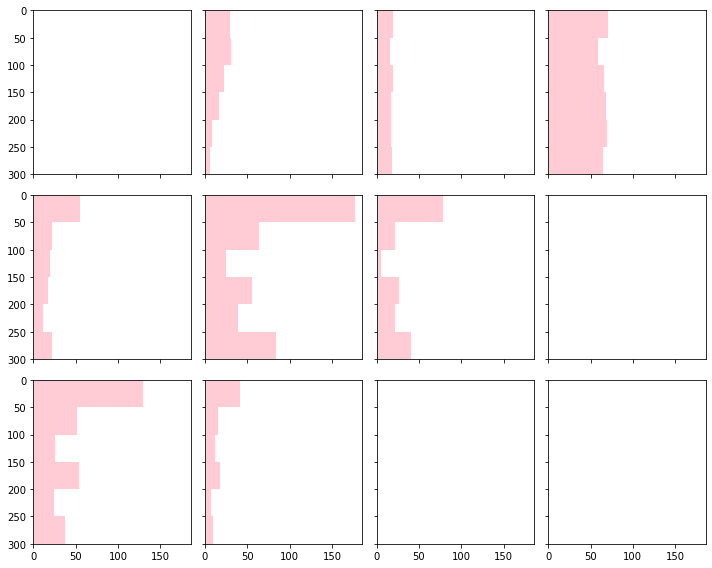

In [37]:
fig, axs = plt.subplots(3, 4, figsize= (10,8),sharey=True, sharex= True, tight_layout=True)

# 2014
axs[0,0].hist(may14w.z, bins=[0,50, 100, 150, 200, 250, 300],color='pink',alpha=0.8, orientation= 'horizontal')
axs[0,1].hist(june14w.z, bins=[0,50, 100, 150, 200, 250, 300],color='pink',alpha=0.8,orientation= 'horizontal')
axs[0,2].hist(july14w.z, bins=[0,50, 100, 150, 200, 250, 300],color='pink',alpha=0.8,orientation= 'horizontal')
axs[0,3].hist(aug14w.z, bins=[0,50, 100, 150, 200, 250, 300],color='pink',alpha=0.8,orientation= 'horizontal')

axs[0,0].set_ylim(0,300)
plt.gca().invert_yaxis()

# axs[0,0].set_title('May 2014')
# axs[0,1].set_title('June 2014')
# axs[0,2].set_title('July 2014')
# axs[0,3].set_title('August 2014')

# axs[0,0].set_ylabel('Count')

# 2019
axs[1,0].hist(may19w.z, bins=[0,50, 100, 150, 200, 250, 300],color='pink',alpha=0.8,orientation= 'horizontal')
axs[1,1].hist(june19w.z, bins=[0,50, 100, 150, 200, 250, 300],color='pink',alpha=0.8,orientation= 'horizontal')
axs[1,2].hist(july19w.z, bins=[0,50, 100, 150, 200, 250, 300],color='pink',alpha=0.8,orientation= 'horizontal')
axs[1,3].hist(aug19w.z, bins=[0,50, 100, 150, 200, 250, 300],color='pink',alpha=0.8,orientation= 'horizontal')

# axs[1,0].set_title('May 2019')
# axs[1,1].set_title('June 2019')
# axs[1,2].set_title('July 2019')
# axs[1,3].set_title('August 2019')

# axs[1,0].set_ylabel('Count')

# 2020
axs[2,0].hist(may20w.z, bins=[0,50, 100, 150, 200, 250, 300],color='pink',alpha=0.8,orientation= 'horizontal')
axs[2,1].hist(june20w.z, bins=[0,50, 100, 150, 200, 250, 300],color='pink',alpha=0.8,orientation= 'horizontal')
axs[2,2].hist(july20w.z, bins=[0,50, 100, 150, 200, 250, 300],color='pink',alpha=0.8,orientation= 'horizontal') # no july, aug 20 data, just pllottimg may14 so that hist same bounds
axs[2,3].hist(aug20w.z, bins=[0,50, 100, 150, 200, 250, 300],color='pink',alpha=0.8,orientation= 'horizontal')


# axs[2,0].set_title('May 2020')
# axs[2,1].set_title('June 2020')
# axs[2,2].set_title('July 2020')
# axs[2,3].set_title('August 2020')

# axs[2,0].set_ylabel('Count')

# axs[2,0].set_xlabel('Depth [m]')
# axs[2,1].set_xlabel('Depth [m]')
# axs[2,2].set_xlabel('Depth [m]')
# axs[2,3].set_xlabel('Depth [m]')

plt.tight_layout()
plt.savefig('figS1_updated.jpg', format='jpg', dpi=400)

### 5. Create histograms of all uninterpolated dives for all months/years

In [39]:
# For DataFrame (concat all years)
allyrs = pd.concat([seal14[['Datetime','LATITUDE','LONGITUDE','Station','z','Temperature [C]','SA','CT','PD']],seal19[['Datetime','LATITUDE','LONGITUDE','Station','z','Temperature [C]','SA','CT','PD']],seal20[['Datetime','LATITUDE','LONGITUDE','Station','z','Temperature [C]','SA','CT','PD']]],axis=0)
allyrs = allyrs[['z','Datetime','LATITUDE', 'LONGITUDE','SA','Temperature [C]','CT','PD']].query('-75.25 < LATITUDE < -74.5 & -104 < LONGITUDE < -100') # PIB
allyrs.reset_index()
allyrs.head()

,z,Datetime,LATITUDE,LONGITUDE,SA,Temperature [C],CT,PD
Pressure [dbar],,,,,,,,
2.000000,1.979256,2014-02-13 00:45:59.999961600,-74.582163,-103.791953,33.802979,-1.100860,-1.095916,27.060583
70.500000,69.757192,2014-02-13 00:45:59.999961600,-74.582163,-103.791953,34.158518,-1.256572,-1.254084,27.352746
118.000000,116.743277,2014-02-13 00:45:59.999961600,-74.582163,-103.791953,34.167143,-1.643146,-1.641466,27.371851
139.100006,137.611530,2014-02-13 00:45:59.999961600,-74.582163,-103.791953,34.171170,-1.620796,-1.619593,27.374475
207.600006,205.344478,2014-02-13 00:45:59.999961600,-74.582163,-103.791953,34.188908,-1.614074,-1.614438,27.388654


In [41]:
# By month
# 2014
may14 = allyrs[(allyrs['Datetime']>='2014-5-1') & (allyrs['Datetime']<'2014-6-1')] 
june14 = allyrs[(allyrs['Datetime']>='2014-6-1') & (allyrs['Datetime']<'2014-7-1')]  
july14 = allyrs[(allyrs['Datetime']>='2014-7-1') & (allyrs['Datetime']<'2014-8-1')] 
aug14 = allyrs[(allyrs['Datetime']>='2014-8-1') & (allyrs['Datetime']<'2014-9-1')] 

# 2019
may19 = allyrs[(allyrs['Datetime']>='2019-5-1') & (allyrs['Datetime']<'2019-6-1')]
june19 = allyrs[(allyrs['Datetime']>='2019-6-1') & (allyrs['Datetime']<'2019-7-1')]
july19 = allyrs[(allyrs['Datetime']>='2019-7-1') & (allyrs['Datetime']<'2019-8-1')]
aug19 = allyrs[(allyrs['Datetime']>='2019-8-1') & (allyrs['Datetime']<'2019-9-1')]

# 2020
may20 = allyrs[(allyrs['Datetime']>='2020-05-01') & (allyrs['Datetime']<'2020-6-1')]
june20 = allyrs[(allyrs['Datetime']>='2020-06-01') & (allyrs['Datetime']<'2020-7-1')] 
july20 = allyrs[(allyrs['Datetime']>='2020-07-01') & (allyrs['Datetime']<'2020-8-1')] 
aug20 = allyrs[(allyrs['Datetime']>='2020-08-01') & (allyrs['Datetime']<'2020-9-1')] 

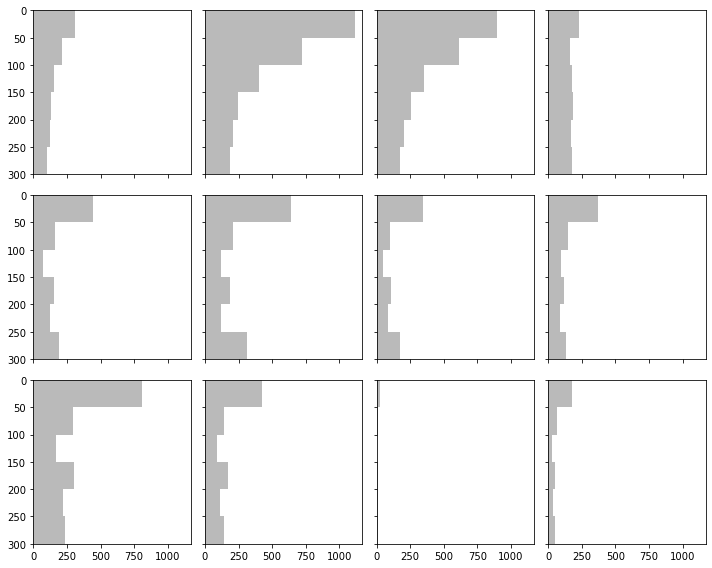

In [42]:
fig, axs = plt.subplots(3, 4, figsize= (10,8),sharey=True, sharex = True, tight_layout=True)

# 2014
axs[0,0].hist(may14.z,bins=[0,50, 100, 150, 200, 250, 300], color='darkgrey',alpha=0.8, orientation='horizontal')
axs[0,1].hist(june14.z,bins=[0,50, 100, 150, 200, 250, 300],color='darkgrey',alpha=0.8, orientation='horizontal')
axs[0,2].hist(july14.z,bins=[0,50, 100, 150, 200, 250, 300],color='darkgrey',alpha=0.8, orientation='horizontal')
axs[0,3].hist(aug14.z,bins=[0,50, 100, 150, 200, 250, 300],color='darkgrey',alpha=0.8, orientation='horizontal')


axs[0,0].set_ylim(0,300)
plt.gca().invert_yaxis()

# axs[0,0].set_title('May 2014')
# axs[0,1].set_title('June 2014')
# axs[0,2].set_title('July 2014')
# axs[0,3].set_title('August 2014')

# axs[0,0].set_ylabel('Count')

# 2019
axs[1,0].hist(may19.z,bins=[0,50, 100, 150, 200, 250, 300],color='darkgrey',alpha=0.8, orientation='horizontal')
axs[1,1].hist(june19.z,bins=[0,50, 100, 150, 200, 250, 300],color='darkgrey',alpha=0.8, orientation='horizontal')
axs[1,2].hist(july19.z,bins=[0,50, 100, 150, 200, 250, 300],color='darkgrey',alpha=0.8, orientation='horizontal')
axs[1,3].hist(aug19.z,bins=[0,50, 100, 150, 200, 250, 300],color='darkgrey',alpha=0.8, orientation='horizontal')

# axs[1,0].set_title('May 2019')
# axs[1,1].set_title('June 2019')
# axs[1,2].set_title('July 2019')
# axs[1,3].set_title('August 2019')

# axs[1,0].set_ylabel('Count')

# 2020
axs[2,0].hist(may20.z,bins=[0,50, 100, 150, 200, 250, 300],color='darkgrey',alpha=0.8, orientation='horizontal')
axs[2,1].hist(june20.z,bins=[0,50, 100, 150, 200, 250, 300],color='darkgrey',alpha=0.8, orientation='horizontal')
axs[2,2].hist(july20.z,bins=[0,50, 100, 150, 200, 250, 300],color='darkgrey',alpha=0.8, orientation='horizontal')
axs[2,3].hist(aug20.z,bins=[0,50, 100, 150, 200, 250, 300],color='darkgrey',alpha=0.8, orientation='horizontal')

# axs[2,0].set_title('May 2020')
# axs[2,1].set_title('June 2020')
# axs[2,2].set_title('July 2020')
# axs[2,3].set_title('August 2020')

# axs[2,0].set_ylabel('Count')

# axs[2,0].set_xlabel('Depth [m]')
# axs[2,1].set_xlabel('Depth [m]')
# axs[2,2].set_xlabel('Depth [m]')
# axs[2,3].set_xlabel('Depth [m]')


plt.savefig('figS2_updated.jpg', format='jpg', dpi=400)